<a href="https://colab.research.google.com/github/yhhscut/regularized_evolution_for_image_classifier/blob/main/regularization_evolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 下载nasbench数据集

# This code was written in TF 1.12 but should be supported all the way through
# TF 1.15. Untested in TF 2.0+.
%tensorflow_version 1.x

# Download the raw data (only 108 epoch data points, for full dataset,
# uncomment the second line for nasbench_full.tfrecord).

!curl -O https://storage.googleapis.com/nasbench/nasbench_only108.tfrecord
# !curl -O https://storage.googleapis.com/nasbench/nasbench_full.tfrecord

# Clone and install the code and dependencies.

!git clone https://github.com/google-research/nasbench
!pip install ./nasbench

# Initialize the NASBench object which parses the raw data into memory (this
# should only be run once as it takes up to a few minutes).
from nasbench import api

# Use nasbench_full.tfrecord for full dataset (run download command above).
nasbench = api.NASBench('nasbench_only108.tfrecord')

TensorFlow 1.x selected.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  498M  100  498M    0     0   122M      0  0:00:04  0:00:04 --:--:--  122M
Cloning into 'nasbench'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 96 (delta 29), reused 22 (delta 22), pack-reused 51
Unpacking objects: 100% (96/96), done.
Processing ./nasbench
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for nasbench: filename=nasbench-1.0-py

In [ ]:
#导入库、设置参数

# Standard imports
import copy
import numpy as np
import matplotlib.pyplot as plt
import random

# Useful constants
INPUT = 'input'
OUTPUT = 'output'
CONV3X3 = 'conv3x3-bn-relu'
CONV1X1 = 'conv1x1-bn-relu'
MAXPOOL3X3 = 'maxpool3x3'
NUM_VERTICES = 7
MAX_EDGES = 9
EDGE_SPOTS = NUM_VERTICES * (NUM_VERTICES - 1) / 2   # Upper triangular matrix
OP_SPOTS = NUM_VERTICES - 2   # Input/output vertices are fixed
ALLOWED_OPS = [CONV3X3, CONV1X1, MAXPOOL3X3]
ALLOWED_EDGES = [0, 1]   # Binary adjacency matrix

In [ ]:
def random_spec():
  """Returns a random valid spec."""
  while True:
    matrix = np.random.choice(ALLOWED_EDGES, size=(NUM_VERTICES, NUM_VERTICES))  # 采样
    matrix = np.triu(matrix, 1)  # 返回上三角，其他置零
    ops = np.random.choice(ALLOWED_OPS, size=(NUM_VERTICES)).tolist()
    ops[0] = INPUT
    ops[-1] = OUTPUT
    spec = api.ModelSpec(matrix=matrix, ops=ops)
    if nasbench.is_valid(spec):
      return spec

def mutate_spec(old_spec, mutation_rate=1.0):
  """Computes a valid mutated spec from the old_spec."""
  while True:
    new_matrix = copy.deepcopy(old_spec.original_matrix)
    new_ops = copy.deepcopy(old_spec.original_ops)

    # In expectation, V edges flipped (note that most end up being pruned).
    # hidden state mutation
    edge_mutation_prob = mutation_rate / NUM_VERTICES
    for src in range(0, NUM_VERTICES - 1):
      for dst in range(src + 1, NUM_VERTICES):
        if random.random() < edge_mutation_prob:
          new_matrix[src, dst] = 1 - new_matrix[src, dst]
          
    # In expectation, one op is resampled.
    op_mutation_prob = mutation_rate / OP_SPOTS
    for ind in range(1, NUM_VERTICES - 1):
      if random.random() < op_mutation_prob:
        available = [o for o in nasbench.config['available_ops'] if o != new_ops[ind]]
        new_ops[ind] = random.choice(available)
        
    new_spec = api.ModelSpec(new_matrix, new_ops)
    if nasbench.is_valid(new_spec):
      return new_spec

# 采样
def random_combination(iterable, sample_size):
  """Random selection from itertools.combinations(iterable, r)."""
  pool = tuple(iterable)
  n = len(pool)
  indices = sorted(random.sample(range(n), sample_size))
  return tuple(pool[i] for i in indices)

def run_evolution_search(max_time_budget=5e6,
                         population_size=50,
                         tournament_size=10,
                         mutation_rate=1.0):
  """Run a single roll-out of regularized evolution to a fixed time budget."""
  nasbench.reset_budget_counters()
  times, best_valids, best_tests = [0.0], [0.0], [0.0]
  population = []   # (validation, spec) tuples

  # For the first population_size individuals, seed the population with randomly
  # generated cells.
  for _ in range(population_size):
    spec = random_spec()
    data = nasbench.query(spec)
    time_spent, _ = nasbench.get_budget_counters()
    times.append(time_spent)
    population.append((data['validation_accuracy'], spec))

    if data['validation_accuracy'] > best_valids[-1]:
      best_valids.append(data['validation_accuracy'])
      best_tests.append(data['test_accuracy'])
    else:
      best_valids.append(best_valids[-1])
      best_tests.append(best_tests[-1])

    if time_spent > max_time_budget:
      break

  # After the population is seeded, proceed with evolving the population.
  while True:
    sample = random_combination(population, tournament_size)
    best_spec = sorted(sample, key=lambda i:i[0])[-1][1]
    new_spec = mutate_spec(best_spec, mutation_rate)

    data = nasbench.query(new_spec)
    time_spent, _ = nasbench.get_budget_counters()
    times.append(time_spent)

    # In regularized evolution, we kill the oldest individual in the population.
    population.append((data['validation_accuracy'], new_spec))
    population.pop(0)

    if data['validation_accuracy'] > best_valids[-1]:
      best_valids.append(data['validation_accuracy'])
      best_tests.append(data['test_accuracy'])
    else:
      best_valids.append(best_valids[-1])
      best_tests.append(best_tests[-1])

    if time_spent > max_time_budget:
      break

  return times, best_valids, best_tests
  

In [ ]:
# Run random search and evolution search 10 times each. This should take a few
# minutes to run. Note that each run would have taken days of compute to
# actually train and evaluate if the dataset were not precomputed.
evolution_data = []
for repeat in range(10):
  print('Running repeat %d' % (repeat + 1))

  times, best_valid, best_test = run_evolution_search()
  evolution_data.append((times, best_valid, best_test))

Running repeat 1
Running repeat 2
Running repeat 3
Running repeat 4
Running repeat 5
Running repeat 6
Running repeat 7
Running repeat 8
Running repeat 9
Running repeat 10


Text(0.5, 1.0, 'Evolution search trajectories (red=validation, blue=test)')

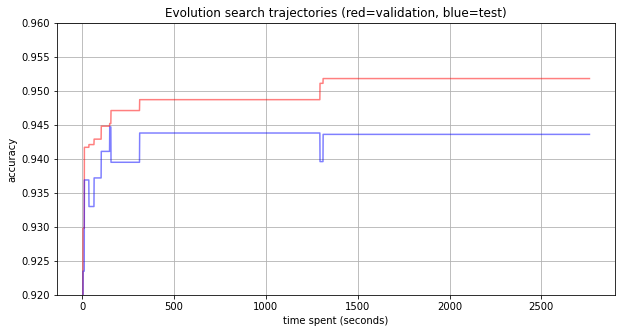

In [ ]:
plt.figure(figsize=(10, 5))
x=np.arange(len(best_test))
#for times, best_valid, best_test in evolution_data:
plt.plot(x, best_valid, label='valid', color='red', alpha=0.5)
plt.plot(x, best_test, label='test', color='blue', alpha=0.5)

plt.ylabel('accuracy')
plt.xlabel('time spent (seconds)')
plt.ylim(0.92, 0.96)
plt.grid()
plt.title('Evolution search trajectories (red=validation, blue=test)')